In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from scipy import ndimage
from func import *
import pyneb as pn


In [2]:
def int_spec_SII(wo_cube,wo_err,brightest_pixel_x,brightest_pixel_y):
    y = np.sum(np.sum(wo_cube[:,brightest_pixel_y-1:brightest_pixel_y+2,brightest_pixel_x-1:brightest_pixel_x+2],axis=1),axis=1)
    y_err = np.sqrt(np.sum(np.sum(((wo_err[:,brightest_pixel_y-1:brightest_pixel_y+2,brightest_pixel_x-1:brightest_pixel_x+2]))**2,axis=1),axis=1))
    return y,y_err

def scale_factor_spectrum(z,data,error,wo_wave):
    k = 1+z
    select1 = (wo_wave>6750*k) & (wo_wave<6850*k)
    cont_dat = data[select1]
    cont_err = error[select1]
    error_maincube = np.std(cont_dat)
    error_errcube = np.mean(cont_err)
    fact = error_maincube/error_errcube
    return fact
    

In [3]:
def popt_central_fit(wo_wave,data,error,obj,z,p_init):
    k = 1+z
    select = (wo_wave>6700*k) & (wo_wave < 6750*k)
    popt_full_fit,pcov_full_fit = leastsq(test_gauss_SII,x0=p_init,args=(wo_wave[select],data[select],error[select]),maxfev = 10000000)
    Monte_Carlo_loops = 100
    parameters_MC = np.zeros((len(popt_full_fit),Monte_Carlo_loops))
    for l in range(Monte_Carlo_loops):
        iteration_data = np.random.normal(data[select],error[select]) 
        popt_MC,pcov_MC =leastsq(test_gauss_SII,x0=popt_full_fit,args=(wo_wave[select],iteration_data,error[select]),maxfev = 10000000)
        parameters_MC[:,l]=popt_MC
        parameters_err = np.std(parameters_MC,1)  
    (amp_SII6716_error,amp_SII6731_error,vel_SII6731_error,vel_sigma_SII6731_error,amp_SII6716_br_error,amp_SII6731_br_error,vel_SII6731_br_error,vel_sigma_SII6731_br_error,m_error,c_error) = parameters_err
    return popt_full_fit,parameters_err 

def electron_density_err(amp_SII6716_fit,amp_SII6716_err,amp_SII6731_fit,amp_SII6731_err,amp_SII6716_br_fit,amp_SII6716_br_err,amp_SII6731_br_fit,amp_SII6731_br_err,MC_loops=1000):  
    Ne_core_temp = np.zeros(MC_loops)
    Ne_wing_temp = np.zeros(MC_loops)
    for m in range(MC_loops):
        (core,wing) = flux_ratio(np.random.normal(amp_SII6716_fit,amp_SII6716_err),np.random.normal(amp_SII6731_fit,amp_SII6731_err),np.random.normal(amp_SII6716_br_fit,amp_SII6716_br_err),np.random.normal(amp_SII6731_br_fit,amp_SII6731_br_err))
        out = electron_density(core,wing)
        Ne_core_temp[m]=out[0]
        Ne_wing_temp[m]=out[1]

    Ne_core_err = np.nanstd(Ne_core_temp)
    Ne_wing_err = np.nanstd(Ne_wing_temp)
    print (Ne_wing_err)
    low = np.percentile(Ne_wing_temp,16)
    high = np.percentile(Ne_wing_temp,84)
    plt.hist(Ne_wing_temp)
    plt.xlabel('Electron Density(/cc)')
    plt.ylabel('Number of Electrons')
    plt.show()
    return Ne_wing_temp,Ne_core_err,Ne_wing_err,low,high


In [4]:
def plot(obj,wo_wave,data,error,z,popt_full_fit,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    (amp_SII6716_fit,amp_SII6731_fit,vel_SII6731_fit,vel_sigma_SII6731_fit,amp_SII6716_br_fit,amp_SII6731_br_fit,vel_SII6731_br_fit,vel_sigma_SII6731_br_fit,m_fit,c_fit) = popt_full_fit
    offset_fit=0.0
    k = 1+z
    select = (wo_wave>6700*k) & (wo_wave < 6750*k)
    
    fit = test_gauss_SII(popt_full_fit,wo_wave[select]+offset_fit,data[select],error[select])*(error[select])+data[select]
    residual = data[select] - fit
    
    fig = plt.gcf()
    fig.set_size_inches(10, 6)    
    plt.plot(wo_wave[select],data[select],color='gray',label='Data',ls='steps-mid',lw = 3)
    #plt.fill_between(wo_wave[select],data[select] - error[select],data[select] + error[select],color = 'gray')
    plt.plot(wo_wave[select],fit,'r-',label='Model')
    plt.plot(wo_wave[select],continuum(wo_wave[select]+offset_fit,m_fit,c_fit) + SII_doublet_gauss(wo_wave[select]+offset_fit,amp_SII6716_fit,amp_SII6731_fit,vel_SII6731_fit,vel_sigma_SII6731_fit),'g--',label='Core')
    plt.plot(wo_wave[select],continuum(wo_wave[select]+offset_fit,m_fit,c_fit) + SII_doublet_gauss(wo_wave[select]+offset_fit,amp_SII6716_br_fit,amp_SII6731_br_fit,vel_SII6731_br_fit,vel_sigma_SII6731_br_fit),'b:',label='Wing')
    
    plt.title('%s 3" [SII] complex modelling'%(obj))
    plt.xlabel(r"Wavelength ($\AA$)")
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ")
    plt.legend()
    fig.savefig('%s/Spectrum/%s/SII/%s_[SII]_model.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
    plt.show()     
    
    fig = plt.gcf()
    fig.set_size_inches(10, 3)  
    plt.plot(wo_wave[select],(residual/error[select]),color='black',label='Excess Flux',drawstyle='steps-mid')
    plt.xlabel(r"Wavelength ($\AA$)")
    plt.ylabel(r"Residual/Error")
    fig.savefig('%s/Spectrum/%s/SII/%s_[SII]_residual.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
    plt.show()

    #select2 = (wo_wave>7560*k) & (wo_wave < 7760*k)
    #plt.plot(wo_wave[select2],data[select2])
    #plt.show()
    #plt.plot(wo_wave[select2],error[select2])
    #plt.show()
    #print np.std(data[select2]),np.mean(error[select2])

    
def hist_plot(Ne_wing_temp):
    plt.hist(Ne_wing_temp)
    plt.xlabel('Electron Density(/cc)')
    plt.ylabel('Number of Electrons')
    plt.show()

In [5]:
def flux_ratio(amp_SII6716_fit,amp_SII6731_fit,amp_SII6716_br_fit,amp_SII6731_br_fit):
    ratio_core = (amp_SII6716_fit/amp_SII6731_fit)
    ratio_wing = (amp_SII6716_br_fit/amp_SII6731_br_fit)
    return ratio_core,ratio_wing 

def electron_density(ratio_core,ratio_wing):
    S2 = pn.Atom('S',2)
    Ne_core = S2.getTemDen(int_ratio=ratio_core,tem=1e4,wave1=6717,wave2=6731)
    Ne_wing = S2.getTemDen(int_ratio=ratio_wing,tem=1e4,wave1=6717,wave2=6731)
    return Ne_core, Ne_wing


In [6]:
def central_table(obj,popt_full_fit,parameters_err,Ne_core,Ne_wing,Ne_core_err,Ne_wing_err):
    (ne,ne_err) = ([Ne_core,Ne_wing],[Ne_core_err,Ne_wing_err])
    (popt,err) = (np.append(popt_full_fit,ne),np.append(parameters_err,ne_err))
    column_names={'amp_SII6716':0,'amp_SII6731':1,'vel_SII':2,'vel_sigma_SII':3,'amp_SII6716_br':4,'amp_SII6731_br':5,'vel_SII_br':6,
              'vel_sigma_SII_br':7,'m':8,'c':9,'n_e_core':10,'n_e_wing':11}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[popt[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s_central_fitSII.fits'%(obj),overwrite=True)

In [7]:
def algorithm_script(obj,z,p_init,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    print ('%s'%(obj))
    
    (wo_cube,wo_err,wo_wave,wo_header) = loadCube('%s/%s/%s.wo_absorption.fits'%(destination_path_cube,obj,obj))
    [x0,y0] = agn_location(obj)
    [brightest_pixel_x,brightest_pixel_y] = [int(x0),int(y0)]
    print (brightest_pixel_x,brightest_pixel_y)
    (data,error) = int_spec_SII(wo_cube,wo_err,brightest_pixel_x,brightest_pixel_y)
    
    factor = scale_factor_spectrum(z,data,error,wo_wave)
    print (factor)
    #error = factor*error
        
    (popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,obj,z,p_init)
    print (popt_full_fit)
    
    (amp_SII6716_fit,amp_SII6731_fit,vel_SII6731_fit,vel_sigma_SII6731_fit,amp_SII6716_br_fit,amp_SII6731_br_fit,vel_SII6731_br_fit,vel_sigma_SII6731_br_fit,m_fit,c_fit) = popt_full_fit
    (amp_SII6716_err,amp_SII6731_err,vel_SII6731_err,vel_sigma_SII6731_err,amp_SII6716_br_err,amp_SII6731_br_err,vel_SII6731_br_err,vel_sigma_SII6731_br_err,m_err,c_err) = parameters_err
    plot(obj,wo_wave,data,error,z,popt_full_fit,destination_path_cube)
    
    (ratio_core,ratio_wing) = flux_ratio(amp_SII6716_fit,amp_SII6731_fit,amp_SII6716_br_fit,amp_SII6731_br_fit)
    
    print (ratio_core,ratio_wing)
    
    (Ne_core, Ne_wing) = electron_density(ratio_core,ratio_wing)
    
    print ('electron_density_core is',Ne_core)
    print ('electron_density_wing is',Ne_wing)
    
    MC_loops = 1000
    Ne_core_temp = np.zeros(MC_loops)
    Ne_wing_temp = np.zeros(MC_loops)
    for m in range(MC_loops):
        (core,wing) = flux_ratio(np.random.normal(amp_SII6716_fit,amp_SII6716_err),np.random.normal(amp_SII6731_fit,amp_SII6731_err),np.random.normal(amp_SII6716_br_fit,amp_SII6716_br_err),np.random.normal(amp_SII6731_br_fit,amp_SII6731_br_err))
        out = electron_density(core,wing)
        Ne_core_temp[m]=out[0]
        Ne_wing_temp[m]=out[1]
    Ne_core_temp[Ne_core_temp > 10000] = np.nan
    Ne_core_temp = Ne_core_temp[np.logical_not(np.isnan(Ne_core_temp))]
    Ne_wing_temp[Ne_wing_temp > 10000] = np.nan
    Ne_wing_temp = Ne_wing_temp[np.logical_not(np.isnan(Ne_wing_temp))]
   
    plt.hist(Ne_wing_temp)
    plt.xlabel('Electron Density(/cc)')
    plt.ylabel('Number of Electrons')
    plt.show()
    Ne_core_err = np.nanstd(Ne_core_temp)
    Ne_wing_err = np.nanstd(Ne_wing_temp)

    low = np.percentile(Ne_wing_temp,16)
    high = np.percentile(Ne_wing_temp,84)
    print ('electron_density_core is',Ne_core, Ne_core_err)
    print ('electron_density_wing is',Ne_wing, Ne_wing_err,low,high)
    #central_table(obj,popt_full_fit,parameters_err,Ne_core,Ne_wing,Ne_core_err,Ne_wing_err)
    #central_table(obj,popt_full_fit,parameters_err)

HE0119-0118
113 80
6.277391
[ 5.82264906e+00  5.64861843e+00  1.64225767e+04  6.93413759e+01
  2.55110473e+00  2.87565523e+00  1.62284417e+04  1.84763947e+02
 -2.36491285e+01  1.75764014e+02]


/home/mainak/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  if sys.path[0] == '':


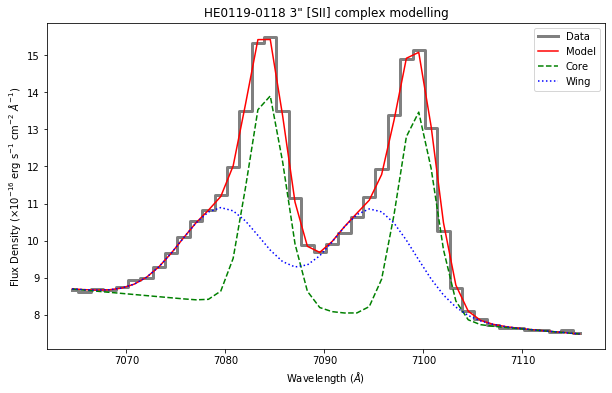

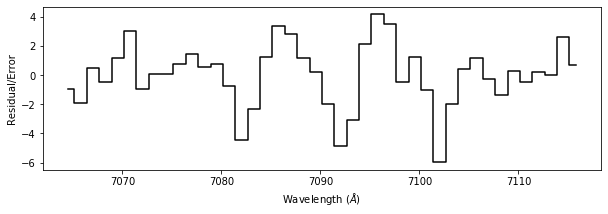

1.0308094147151443 0.8871385889613157
electron_density_core is 438.7071887566721
electron_density_wing is 775.3528087326977


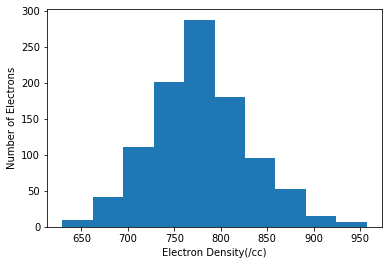

electron_density_core is 438.7071887566721 25.42792046800972
electron_density_wing is 775.3528087326977 52.30613861136463 726.5908522088351 828.0123603712216


In [10]:
#z = {"HE0021-1819":0.053197,"HE0119-0118":0.054341,"HE0253-1641":0.031588,"HE0433-1028":0.035550
#    ,"HE0934+0119":0.050338,"HE1011-0403":0.058314,"HE1108-2813":0.058,"HE2302-0857":0.046860}

z = {"HE0119-0118":0.054341}

objs = z.keys()

p_init = {'HE0119-0118':[5,5,16302,50,2,2,16102,100,-0.001,0.1]}


for obj in objs:
    algorithm_script(obj,z[obj],p_init[obj])
    
# It is suspicious. But also something to do with its strong wing.


HE2302-0857
139 160
10.587071
[ 3.23991422e+00  3.41497657e+00  1.40396738e+04  9.92234952e+01
  4.76013740e+00  4.53714573e+00  1.41960946e+04  1.72595389e+02
 -2.18403078e+01  1.65214636e+02]


/home/mainak/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  if sys.path[0] == '':


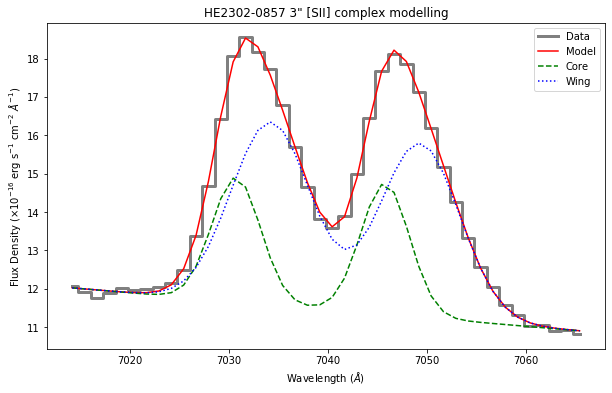

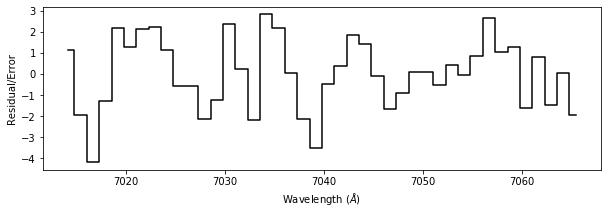

0.9487368806353169 1.0491480073154056
electron_density_core is 607.964159685768
electron_density_wing is 407.09999285380286


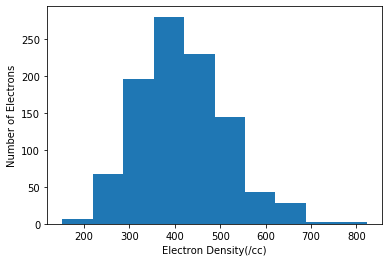

electron_density_core is 607.964159685768 243.97871900232536
electron_density_wing is 407.09999285380286 96.5453339672801 324.56080816314216 508.9512988575814


In [8]:
z = {"HE2302-0857":0.046860}

objs = z.keys()

p_init = {'HE2302-0857':[5,5,14058,50,2,2,14258,200,-0.001,0.1]}


for obj in objs:
    algorithm_script(obj,z[obj],p_init[obj]) 


HE0433-1028
150 157
4.3244767
[ 3.89944133e+00  4.01367608e+00  1.06806298e+04  9.11614582e+01
  8.64237264e-01  1.39078080e+00  1.04867335e+04  2.28166631e+02
 -2.52971927e+01  1.86608949e+02]


/home/mainak/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  if sys.path[0] == '':


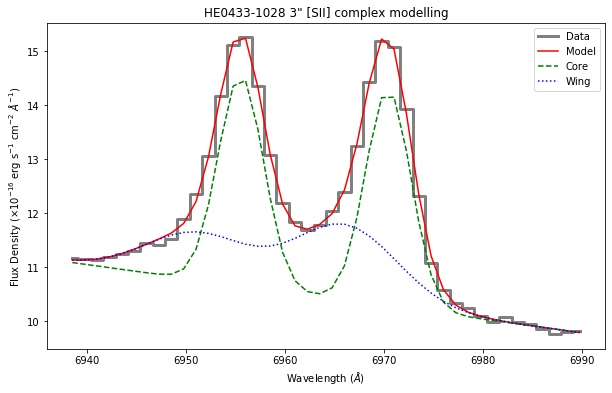

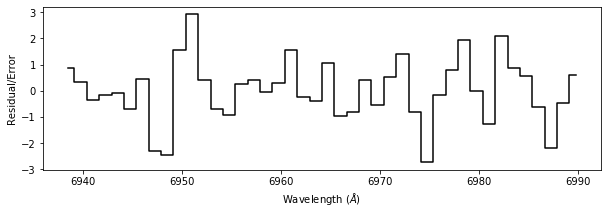

0.9715386223992545 0.6214043692861992
electron_density_core is 556.9651699425564
electron_density_wing is 2730.8839905630257


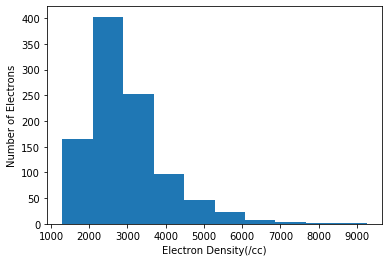

electron_density_core is 556.9651699425564 57.96192659674347
electron_density_wing is 2730.8839905630257 1012.0332392129957 2088.609806204046 3773.0660807306513


In [10]:
z = {"HE0433-1028":0.035550}

objs = z.keys()

p_init = {'HE0433-1028':[3.89944166e+00,  4.01367431e+00,  1.06806299e+04,  9.11614295e+01,
  8.64238424e-01,  1.39078255e+00,  1.04867339e+04,  2.28166289e+02,
 -2.52972086e+01,  1.86609060e+02]}

for obj in objs:
    algorithm_script(obj,z[obj],p_init[obj]) 


HE0253-1641
96 41
2.593429
[ 8.70100554e+00  7.31887623e+00  9.59775102e+03 -8.65661058e+01
  2.72423014e+00  5.00291260e+00  9.48935796e+03  1.98773845e+02
 -1.83977548e+01  1.51023687e+02]


/home/mainak/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  if sys.path[0] == '':


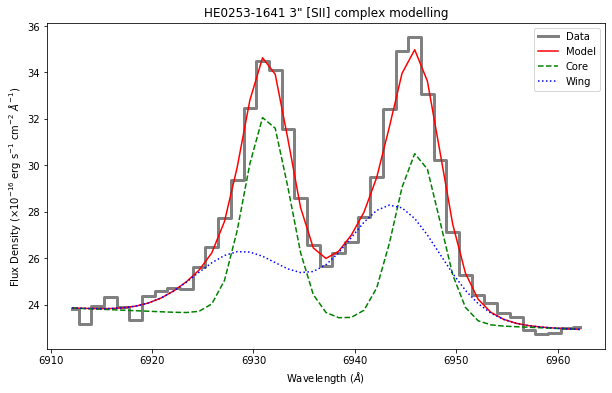

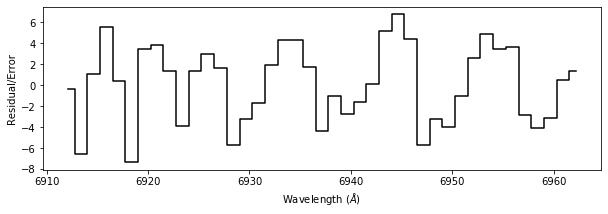

1.1888444713156832 0.544528829716343
electron_density_core is 217.00171173160047
electron_density_wing is 4989.541062434622


/home/mainak/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater


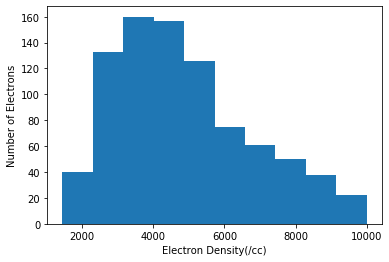

electron_density_core is 217.00171173160047 74.82505328855115
electron_density_wing is 4989.541062434622 1913.9353199367083 3030.88570959951 6992.931677562768


In [11]:
z = {"HE0253-1641":0.031588}

objs = z.keys()

p_init = {'HE0253-1641':[5,5,9476,50,2,2,9276,100,-0.001,0.1]}


for obj in objs:
    algorithm_script(obj,z[obj],p_init[obj]) 


HE0108-4743
79 79
3.6170926
[ 7.27616008e+00  5.94867937e+00  7.17989174e+03  4.54057169e+01
  2.43924890e+00  2.44011700e+00  7.15736978e+03  1.16167489e+02
 -6.86491450e-01  1.01889479e+01]


/home/mainak/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  if sys.path[0] == '':


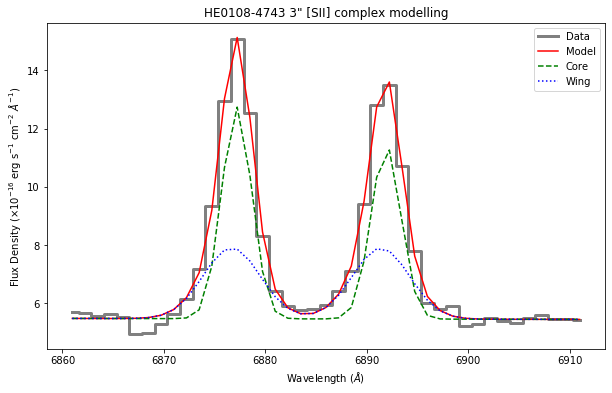

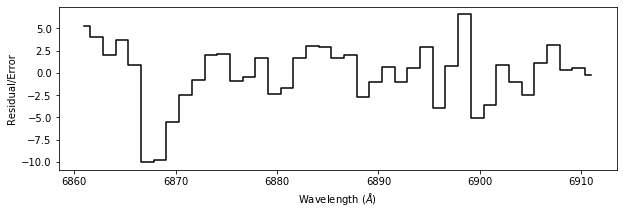

1.2231555316318634 0.9996442383980862
electron_density_core is 179.66313659361543
electron_density_wing is 497.3080942268323


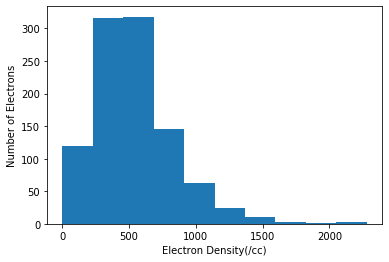

electron_density_core is 179.66313659361543 56.000976477656
electron_density_wing is 497.3080942268323 290.21077679769866 265.08648882231165 801.3353121787311


In [12]:
z = {"HE0108-4743":0.02392}

objs = z.keys()

p_init = {'HE0108-4743':[5,5,7176,50,2,2,7076,100,-0.001,0.1]}


for obj in objs:
    algorithm_script(obj,z[obj],p_init[obj]) 


HE0040-1105
191 151
1.7592329
[ 1.89936507e+00  1.76658670e+00  1.25813106e+04  7.98626324e+01
  1.28893399e-01  1.87894335e-01  1.22700264e+04  1.07694038e+02
 -3.87146436e+00  2.85471544e+01]


/home/mainak/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  if sys.path[0] == '':


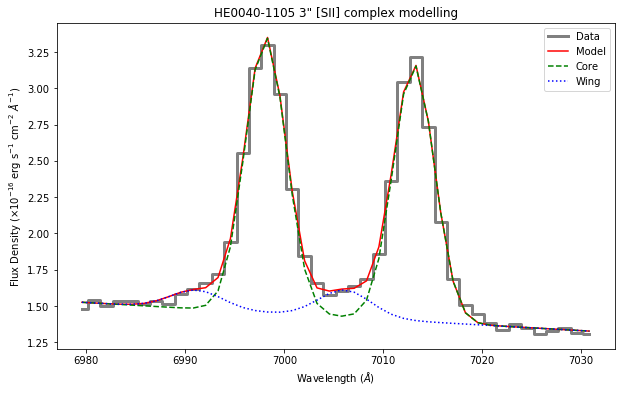

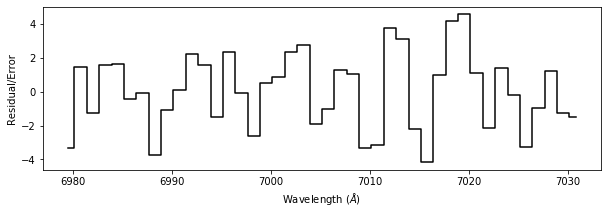

1.075160969416001 0.6859887424289095
electron_density_core is 366.2509439770235
electron_density_wing is 1881.8760021964836


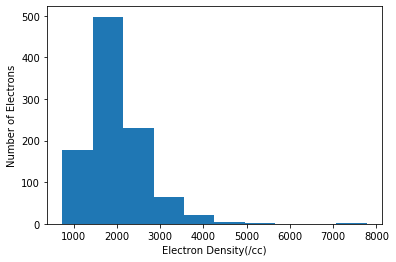

electron_density_core is 366.2509439770235 16.291109774978473
electron_density_wing is 1881.8760021964836 651.349251921189 1411.291189981732 2542.4164754115445


In [13]:
z = {"HE0040-1105":0.041692}

objs = z.keys()

p_init = {'HE0040-1105':[1.9,1.8,12581,80,0.13,0.19,12270,110,-3.87,28.54]}


for obj in objs:
    algorithm_script(obj,z[obj],p_init[obj]) 


HE0224-2834
81 77
2.6435316
[ 1.33923979e+00  1.14720622e+00  1.80444827e+04  1.28683517e+02
  2.90586020e-01  4.48267955e-01  1.79301563e+04  5.60713556e+01
 -4.90029956e+00  3.80626202e+01]


/home/mainak/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  if sys.path[0] == '':


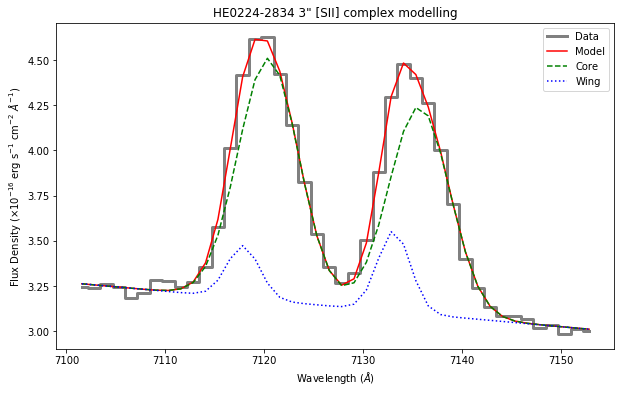

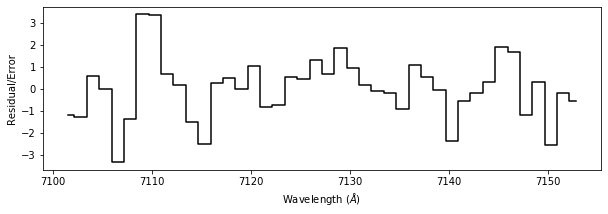

1.167392374496579 0.6482417867425878
electron_density_core is 241.38680052571266
electron_density_wing is 2311.0617750192014


/home/mainak/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater


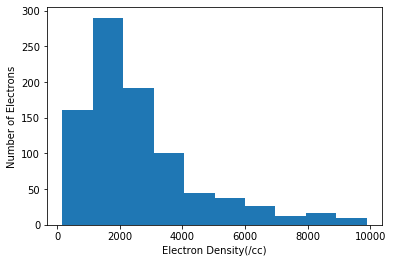

electron_density_core is 241.38680052571266 66.31618275643676
electron_density_wing is 2311.0617750192014 1859.955570704672 1091.6689114384876 4116.070913379949


In [19]:
z = {"HE0224-2834":0.059800}

objs = z.keys()

p_init = {'HE0224-2834':[1.28347008e+00,1.08543217e+00,1.80556524e+04,1.23064387e+02,3.99785108e-01,5.61026655e-01,1.79296652e+04,6.42081964e+01,-6.73939395e+00,5.09879797e+01]}

for obj in objs:
    algorithm_script(obj,z[obj],p_init[obj]) 